-----
## Dataset Management Utilities

This file creates the load_and_preprocess_data.py file, then imports it and runs some tests on the methods to confirm they are working as expected.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
%%writefile load_and_preprocess_data.py
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import KFold

class TrainDataInfo:
    def __init__(self, file_map, country_names, country_counts, sampling_probs, weight_scalars):
        '''
        Make copies of all the inputs, then we'll define a few accessor methods
        '''
        self.filename_map = file_map.copy()     # dict(country_name -> filename_list)
        self.country_names = country_names[:]   # sorted country names
        self.sampling_probs = sampling_probs[:] # sampling probabilities (sorted by name)
        self.weight_scalars = weight_scalars[:] # loss fn weight scalars (sorted by name)
        
        self.country_counts = [len(self.filename_map[c]) for c in self.country_names]
        
    # The vectors above are stored in country-name sorted order, even though filename_map
    # doesn't have any ordering.  But it is still nice to be able to query values by name.
    def get_country_count(self, country):
        return self.country_counts[self.country_names.index(country)]
    
    def get_sampling_prob(self, country):
        return self.sampling_probs[self.country_names.index(country)]
    
    def get_weight_scalars(self, country):
        return self.weight_scalars[self.country_names.index(country)]
   

Overwriting load_and_preprocess_data.py


In [71]:
%%writefile -a load_and_preprocess_data.py
    
def collect_filename_mapping(train_folder):
    file_map = defaultdict(lambda: list())
    country_counts = []

    for root,subs,files in os.walk(train_folder):
        country = os.path.split(root.lstrip(train_folder))[1]
        if len(country.strip()) == 0:
            continue

        for f in files:
            if not os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                continue

            file_map[country].append(os.path.join(root, f))

    # Sorted names, which will match the sampling probs and weight vectors
    country_names = sorted(file_map.keys())
    country_counts = [len(file_map[c]) for c in country_names]
    for country in country_names:
        file_map[country] = sorted(file_map[country])
        
    # We're going to sample from the classes proportional to sqrt(N)
    sampling_probs = np.sqrt(np.array(country_counts)) 
    sampling_probs = sampling_probs / np.sum(sampling_probs)

    # When we actually do training, we want to scale gradient updates by 1/sqrt(N)
    weight_scalars = 1.0 / sampling_probs
    #weight_scalars = weight_scalars / min(weight_scalars)
    weight_scalars = np.clip(weight_scalars / np.mean(weight_scalars), 0.8, 2.0)

    return TrainDataInfo(file_map, country_names, country_counts, sampling_probs, weight_scalars)


def get_kfold_train_test(ds_size, shards=5, shard_test_index=None, shuffle=True):
    kf = KFold(n_splits=shards, shuffle=shuffle, random_state=31415926)
    if shard_test_index is None:
        return [(train,test) for train,test in kf.split(range(ds_size))]
    else:
        # We're looking for a specific split.  But kf.split() produces 
        # a generator, so you have to iterate if you want a specific one
        for i,traintest in enumerate(kf.split(range(ds_size))):
            if i == shard_test_index:
                return traintest
        else:
            raise Exception('Something went terribly wrong!')
    
    
def distributed_train_test_split(all_fn_map, shards=5, shard_test_index=0):
    """
    We are going to do a test-train split but within each class/country, so that we can
    manage sampling rates (oversampling Armenia, Australia, undersampling Russia, etc)
    """
    train_fn_map = defaultdict(lambda: [])
    val_fn_map = defaultdict(lambda: [])
    
    for country,fn_list in all_fn_map.items():
        n_files = len(fn_list)
        train_indices, test_indices = get_kfold_train_test(n_files, shards, shard_test_index)
        train_fn_map[country] = [all_fn_map[country][i] for i in train_indices]
        val_fn_map[country] = [all_fn_map[country][i] for i in test_indices]
    
    return train_fn_map, val_fn_map


def get_country_sample(n_country, names, sampling_probs, *, with_replace):
    """
    For triplet loss, need 2 no replacement; general training needs batch size w/ replacement
    This should be called with names and probs from the master train_info object
    """
    if not with_replace and n_country > len(names):
        raise Exception(f'Cannot take {n_country} samples w/o replacement, list size is {len(names)}')
        
    idx_choice = np.random.choice(len(names), size=n_country, p=sampling_probs, replace=with_replace)
    
    # We actually need to return the number of images to pull from each country
    counts = Counter([names[i] for i in idx_choice])
    return counts


def get_image_fn_sample(fn_map, n_img, country, *, with_replace):
    """
    Given the filename mapping, select {n_img} images for the specified country
    This should be called with training set of the split dataset
    """
    if not with_replace and n_img > len(fn_map[country]):
        raise Exception(f'Cannot take {count} samples w/o replacement, list size is {len(names)}')
        
    return np.random.choice(fn_map[country], size=n_img, replace=with_replace)
    
    

def display_rel_counts(train_info):
        
    trunc_names = [n[:12] for n in train_info.country_names]
    counts = train_info.country_counts 
    sample_rates = train_info.sampling_probs
    weights = train_info.weight_scalars
    
    fig,axs = plt.subplots(1, 3, figsize=(15,5))
    
    sns.barplot(trunc_names, counts, ax=axs[0])
    axs[0].plot([-1, len(counts)], [min(counts)]*2, 'r-.')
    axs[0].plot([-1, len(counts)], [max(counts)]*2, 'r-.')
    axs[0].set_title('Number of Files per Class')
    axs[0].set_ylabel('Raw Image/File Count')
    for tick in axs[0].get_xticklabels():
        tick.set_rotation(90)
    
    sns.barplot(trunc_names, sample_rates, ax=axs[1])
    axs[1].plot([-1, len(counts)], [min(sample_rates)]*2, 'r-.')
    axs[1].plot([-1, len(counts)], [max(sample_rates)]*2, 'r-.')
    axs[1].set_title('Sampling Probabilities for Training')
    axs[1].set_ylabel('Sampling Probability')
    for tick in axs[1].get_xticklabels():
        tick.set_rotation(90)
                        
    sns.barplot(trunc_names, weights, ax=axs[2])
    axs[2].set_title('Loss Function Weighting')
    axs[2].set_ylabel('Relative weight')
    axs[2].plot([-1, len(counts)], [1.0, 1.0], 'r-.')
    for tick in axs[2].get_xticklabels():
        tick.set_rotation(90)

Appending to load_and_preprocess_data.py


-----
## Testing Utility Methods
Test the methods above to confirm they do what we expect them to.  Since some of these are randomization utilities, it would be a lot of work to verify them automatically, so instead we will just visually inspect results.

In [72]:
# Above cell simply wrote out the .py file.  Need to import it now.
from load_and_preprocess_data import *

In [73]:
train_info = collect_filename_mapping('train_imgs')
total_imgs = 0
fn_map = train_info.filename_map

# These are primarily for display purposes
for country in train_info.country_names:
    n_imgs = train_info.get_country_count(country)
    total_imgs += n_imgs
    print(f'Country {country.ljust(30)} has {n_imgs} images')
print(f'Total image count across all countries: {total_imgs}')

Country Armenia                        has 11 images
Country Australia                      has 35 images
Country Germany                        has 107 images
Country Hungary+Slovakia+Croatia       has 49 images
Country Indonesia-Bali                 has 45 images
Country Japan                          has 62 images
Country Malaysia+Indonesia             has 55 images
Country Portugal+Brazil                has 54 images
Country Russia                         has 124 images
Country Spain                          has 68 images
Country Thailand                       has 104 images
Total image count across all countries: 714


## Sampling Probabilities and Loss Function Weighting
The method should have provided us w


Russia has 11.3x as many images as Armenia
Reduced to  3.4x by using sqrt(N) for sampling rates
This effectively undersamples the countries with high counts, oversamples low counts
Further, we will multiple gradients by a weighting factor, higher for smaller counts



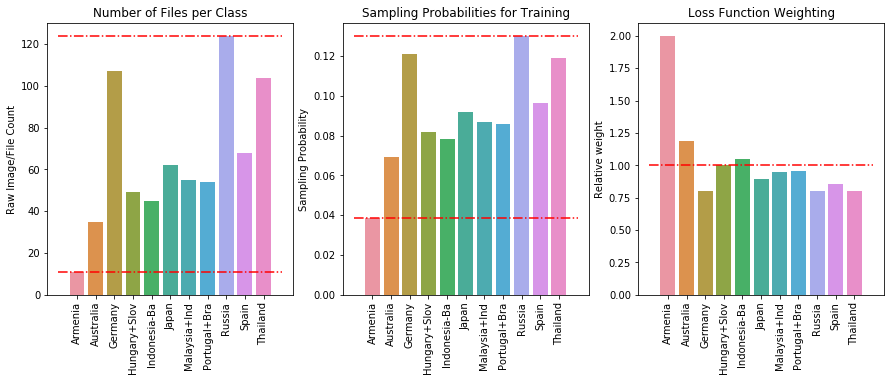

In [74]:
display_rel_counts(train_info)

all_counts = train_info.country_counts
max_idx = np.argmax(all_counts)
min_idx = np.argmin(all_counts)
max_name = train_info.country_names[max_idx]
min_name = train_info.country_names[min_idx]
ratio_counts =  train_info.country_counts[max_idx] / float(train_info.country_counts[min_idx])
ratio_sample =  train_info.sampling_probs[max_idx] / train_info.sampling_probs[min_idx]
print('')
print(f'{max_name} has {ratio_counts:.1f}x as many images as {min_name}')
print(f'Reduced to  {ratio_sample:.1f}x by using sqrt(N) for sampling rates')
print(f'This effectively undersamples the countries with high counts, oversamples low counts')
print(f'Further, we will multiple gradients by a weighting factor, higher for smaller counts')
print('')

In [33]:
train_spl, test_spl = distributed_train_test_split(train_info.filename_map, shards=5, shard_test_index=0)

print('Training data:')
for country, fn_list in train_spl.items():
    n_total = train_info.country_counts[train_info.country_names.index(country)]
    print(f'   Samples from country {country.ljust(30)}: {len(fn_list)} / {n_total}')
    
print('\nTesting data:')
for country, fn_list in test_spl.items():
    n_total = train_info.country_counts[train_info.country_names.index(country)]
    print(f'   Samples from country {country.ljust(30)}: {len(fn_list)} / {n_total}')
    
country = train_info.country_names[0]
print(f'\nSample entries for {country}')
for fn in train_info.filename_map[country]:
    print('  ', fn)


Training data:
   Samples from country Australia                     : 28 / 35
   Samples from country Thailand                      : 83 / 104
   Samples from country Indonesia-Bali                : 36 / 45
   Samples from country Portugal+Brazil               : 43 / 54
   Samples from country Germany                       : 85 / 107
   Samples from country Malaysia+Indonesia            : 44 / 55
   Samples from country Spain                         : 54 / 68
   Samples from country Russia                        : 99 / 124
   Samples from country Hungary+Slovakia+Croatia      : 39 / 49
   Samples from country Japan                         : 49 / 62
   Samples from country Armenia                       : 8 / 11

Testing data:
   Samples from country Australia                     : 7 / 35
   Samples from country Thailand                      : 21 / 104
   Samples from country Indonesia-Bali                : 9 / 45
   Samples from country Portugal+Brazil               : 11 / 54
   Sample

In [61]:
c_names = train_info.country_names
s_probs = train_info.sampling_probs

print('Here is an example batch of 100 images, sampled using sqrt(N) probs:')
sample_counts = get_country_sample(100, c_names, s_probs, with_replace=True)
for ct, country in sorted([(ct,country) for country,ct in sample_counts.items()]):
    print(f'  {ct}  images for country {country}')

Here is an example batch of 100 images, sampled using sqrt(N) probs:
  4  images for country Australia
  5  images for country Armenia
  7  images for country Hungary+Slovakia+Croatia
  7  images for country Japan
  8  images for country Indonesia-Bali
  10  images for country Germany
  10  images for country Thailand
  11  images for country Malaysia+Indonesia
  12  images for country Portugal+Brazil
  12  images for country Spain
  14  images for country Russia


In [66]:
# Test no-replacement 
for i in range(1000):
    two_countries = get_country_sample(2, c_names, s_probs, with_replace=False)
    assert len(two_countries) == 2
else:
    print('Sampling without replacement seems to work')
    

Sampling without replacement seems to work
